In [1]:
import torch
import models

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
#import seaborn as sns
from matplotlib import patches

def plot_2d_sample(sample, mu=None, sig=None, idx=(0,1)):
    """
    :param sample: 
    :param mu:
    :param sig: 
    :return:
    """
    #fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.cla()
    
    sample_np = sample.numpy()
    x = sample_np[:, idx[0]]
    y = sample_np[:, idx[1]]
    ax.scatter(x, y)

    if (mu is not None and sig is not None):
        for i in range(mu.shape[0]):
            ellipse = patches.Ellipse( (mu[i,idx[0]], mu[i,idx[1]]) , 2*sig[i], 2*sig[i], color='r', fill=False) 
            ax.add_artist(ellipse)
    plt.axis('equal')
    plt.show()

In [4]:
from torchvision import datasets, transforms

batch_size = 100
test_batch_size = 10


class Transpose(object):
    def __init__(self):
        pass
    def __call__(self, data):
        return data.transpose(-1,-2)

transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

transform = transforms.ToTensor()

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=test_batch_size, shuffle=False)
gmm_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=3000, shuffle=True)

#EMNIST is rotated 90 degrees from MNIST
EMNIST_train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='letters', download=True, train=True, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=batch_size, shuffle=True)

EMNIST_test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='letters', download=True, train=False, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=test_batch_size, shuffle=True)

EMNIST_test_loader_digits = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='digits', download=True, train=False, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=test_batch_size, shuffle=True)

X_MNIST = enumerate(gmm_loader).__next__()[1][0].view(gmm_loader.batch_size, 784)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

def train_vanilla(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train(model, device, train_loader, optimizer, epoch, adv_loader, verbose=True):
    model.train()
    min_loss = torch.tensor(10.).log()
    #for batch_idx, (data, target) in enumerate(train_loader):
    for ((batch_idx, (data, target)), (_, (data_adv, _))) in zip(enumerate(train_loader),enumerate(adv_loader)):
        data, target = data.to(device), target.to(device)
        data_adv = data_adv.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        #input_rand = torch.rand(train_loader.batch_size,1,28,28).to(device)
        #output_rand = model(input_rand)
        output_rand = model(data_adv)

        loss = F.nll_loss(output, target) - .1*output_rand.sum()/(10*train_loader.batch_size)
        loss.backward()
        a = torch.isnan(model.gmm.mu.grad).sum()
        b = torch.isnan(model.gmm.logvar.grad).sum()
        c = torch.isnan(model.gmm.alpha.grad).sum()

        if (a+b+c)>0:
            return loss, output, target, data_adv, data
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    av_conf = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            correct += (pred.eq(target.view_as(pred))*(c.exp()>0.5)).sum().item()
            av_conf += c.exp().sum().item()
            
    test_loss /= len(test_loader.dataset)
    av_conf /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Ave. Confidence: {:.0f}%\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), 100. * av_conf))
    return correct, av_conf
    
def test_adv(model, device, adv_test_loader):
    model.eval()
    av_conf = 0
    with torch.no_grad():
        for data, _ in adv_test_loader:
            data = data.to(device)
            output = model(data)

            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            av_conf += c.exp().sum().item()
            
    av_conf /= len(adv_test_loader.dataset)

    print('\nAve. Confidence: {:.0f}%\n'.format(100.*av_conf))
    return av_conf

In [11]:
base_model = models.NetVanilla().to(device)

In [12]:
import torch.optim as optim

lr = .001
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum)
for epoch in range(10):
    train_vanilla(base_model, device, train_loader, optimizer_base, epoch)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303767
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.291318
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.256642
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.182833
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.691913
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.836762
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.557184
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.511068
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.365354
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.247515
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.332074
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.430568
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.274913
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.336816
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.272021
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.197470
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.231149
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.115371
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.224728
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.148863
Train Epoch: 3 [2000

In [13]:
torch.save(base_model, 'base_model.pth')

In [ ]:
base_model = torch.load('base_model.pth')
model = models.Net(base_model, X_MNIST, 1000, -764.).to(device)
torch.save(model, 'gmm_model.pth')

/home/alexm/project/notebooks/gmm-robust/models.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = (X[:,None,:]-torch.tensor(self.mu.data[None,:,:], dtype=torch.float)).norm(dim=2).min(dim=1)[1]


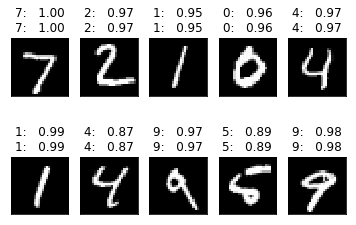


Test set: Average loss: 0.0869, Accuracy: 9765/10000 (98%), Ave. Confidence: 94%


Test set: Average loss: 0.0869, Accuracy: 9765/10000 (98%), Ave. Confidence: 94%


Ave. Confidence: 49%


Ave. Confidence: 49%



0.4929398216077915

In [572]:
#model.log_pz_lam.data = torch.tensor(-767.132, device=device)
data = enumerate(test_loader).__next__()[1][0]
y = model(data.to(device))
y_base = base_model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y_base.argmax(1)[i].item()) + ":   %.2f" % y_base[i].max().exp().item()
              +'\n'
              +str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item()
             )
    plt.imshow(data[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

#model.log_pz_lam = torch.tensor(-763., device=device)
test(model, device, test_loader)
test(base_model, device, test_loader)

test_adv(model, device, EMNIST_test_loader)
test_adv(base_model, device, EMNIST_test_loader)

In [570]:
lr = .001
momentum = .9

optimizer = optim.SGD( model.parameters(), lr=lr, momentum=momentum)
for epoch in range(1):
    train(model, device, train_loader, optimizer, epoch, EMNIST_train_loader)
    #train_vanilla(model, device, train_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.841768
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.488239
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.471570
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.495308
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.416114
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.419273


In [571]:

print(model.log_pz_lam.grad)
print(model.log_pz_lam)

tensor(-7.8162e-06, device='cuda:0')
Parameter containing:
tensor(-764.0056, device='cuda:0', requires_grad=True)


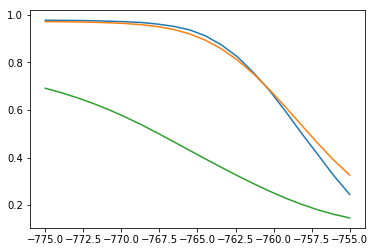

In [525]:
correct = []
conf_MNIST = []
conf_EMNIST = []
lam_vec = torch.linspace(-775.,-755, 20)
for lam in lam_vec:
    model.log_pz_lam.data = torch.tensor(lam, device=device)

    a, b = test(model, device, test_loader)
    correct.append(a)
    conf_MNIST.append(b)

    conf_EMNIST.append(test_adv(model, device, EMNIST_test_loader))

#fig=plt.figure(figsize=(20, 6))
plt.plot(lam_vec.numpy(), np.array(correct)/10000)
plt.plot(lam_vec.numpy(), conf_MNIST)
plt.plot(lam_vec.numpy(), conf_EMNIST)

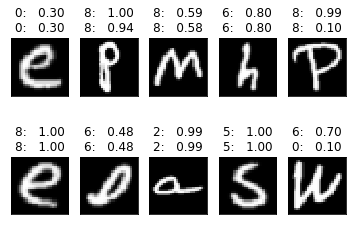


Ave. Confidence: 70%


Ave. Confidence: 80%



0.8004278125900489

In [564]:
data = enumerate(EMNIST_test_loader).__next__()[1][0]
y = model(data.to(device))
y_base = base_model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y_base.argmax(1)[i].item()) + ":   %.2f" % y_base[i].max().exp().item()
              +'\n'
              +str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item()
             )
    plt.imshow(data[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

test_adv(model, device, EMNIST_test_loader)
test_adv(base_model, device, EMNIST_test_loader)

In [487]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = model(data)
        base_output = base_model(data)
        c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
        c, pred_base = output.max(1, keepdim=True) # get the index of the max log-probability
        if any(pred!= pred_base):
            print('hi')


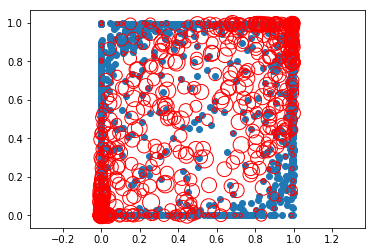

In [574]:
plot_2d_sample(X_MNIST,model.gmm.mu, (model.gmm.logvar/2).exp()/100,idx=(345,346))

In [573]:
test(model, device, EMNIST_test_loader_digits)
test(base_model, device, EMNIST_test_loader_digits)



Test set: Average loss: 0.4599, Accuracy: 31865/40000 (80%), Ave. Confidence: 76%


Test set: Average loss: 0.4556, Accuracy: 31961/40000 (80%), Ave. Confidence: 77%



(31961, 0.7668706594467163)

In [ ]:
noise = (2*data.mean()*torch.rand((10,1,28,28)))
noise = noise.to(device).requires_grad_()


epsilon = 7.
alpha = .01
image = noise
perturbed_image = image
for _ in range(10):
    y = robust_model(perturbed_image)
    loss = -y.sum()
    loss.backward()
    
    with torch.no_grad():
        perturbed_image += alpha*image.grad
        # Adding clipping to maintain [0,1] range
        delta = perturbed_image-image
        delta /= delta.view((10,784)).norm(dim=1)[:,None,None,None]
        delta *= epsilon
        perturbed_image = image + delta
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        print(str(loss.item()) + '\t'+ str((perturbed_image-image).view((10,784)).norm(dim=1).max().item()))
        perturbed_image = perturbed_image.detach()